In [1]:
import Robogame as rg
import networkx as nx
import altair as alt
import time, json
import pandas as pd
import numpy as np

To start a game server go into the server directory. Make sure you have flask and networkx installed (```conda install networkx flask flask-cors requests scipy``` should do it).

To start a server do:

```python api.py [-d directoryforgame] [-s] [-t1s T1Secret] [-t2s T2Secret] gameid```

gameid is the the prefix of all the game files (the examples we gave you are examplematch1, examplematch2, examplematch3.

```
-d/--directory is an optional directory. For example, we put the examplematch1 files in the example1 directory
-s/--simulated tells us whether to simulate team 2
-t1s/--team1secret is Team 1's secret. If you don't specify this, the server will give you one
-t2s/--team1secret is Team 2's secret. This is ignored if you use -s. If you don't specify this, the server will give you one
-m/--matchsave is a log file to save the game in, a random log name will be used if you don't specify this
```

Here's a simple game:

```python api.py -d ./example1 -s -t1s bob examplematch1```

We're using the examplematch1 files in the example1 directory, simulating player 2 and team 1's secret is 'bob' (that's us)

In [2]:
# create a game connection using bob as the "secret" key for your team (this is what you're given by the server)
game = rg.Robogame("bob")

# the default is to the localhost on port 5000, if you want something else you can do:
# game = rg.Robogame("bob",server="12.12.31.1",port=2324)

In [3]:
# tell the server we're ready to go
game.setReady()

{'Result': 'OK'}

In [4]:
game.getGameTime()

{'curtime': 0,
 'gameendtime_secs': 1607630760.0642319,
 'gamestarttime_secs': 1607630160.0642319,
 'servertime_secs': 1607630150.07876,
 'unitsleft': 100}

In [5]:
# get the current game time
# there is a buffer before the game actually starts once both teams are ready

# wait for both players to be ready
while(True):
    gametime = game.getGameTime()
    timetogo = gametime['gamestarttime_secs'] - gametime['servertime_secs']
    
    if ('Error' in gametime):
        print("Error"+str(gametime))
        break
    if (timetogo <= 0):
        print("Let's go!")
        break
        
    print("waiting to launch... game will start in " + str(int(timetogo)))
    time.sleep(1) # sleep 1 second at a time, wait for the game to start
    

waiting to launch... game will start in 9
waiting to launch... game will start in 8
waiting to launch... game will start in 7
waiting to launch... game will start in 6
waiting to launch... game will start in 5
waiting to launch... game will start in 4
waiting to launch... game will start in 3
waiting to launch... game will start in 2
waiting to launch... game will start in 1
waiting to launch... game will start in 0
Let's go!


In [6]:
# check the current game time
game.getGameTime()

{'curtime': 0.03,
 'gameendtime_secs': 1607630760.0642319,
 'gamestarttime_secs': 1607630160.0642319,
 'servertime_secs': 1607630160.233807,
 'unitsleft': 99.97}

In [7]:
# get the robot data (note that the bets column are the guesses your team has associated with the robots at the moment)
robots = game.getRobotInfo()

# if you want this in json format, do:
# robots = game.getRobotInfo(js=True)

In [8]:
# see what's inside
robots.sample(10)

,id,name,expires,winner,Productivity,bets
130,130,Stonevator Botchik,NaN,-2,NaN,-1
46,46,Excahauler Boterson Jr.,24.0,-2,NaN,-1
13,13,Waterhauler Boterson,97.0,-2,NaN,-1
133,133,Pullminer Botberg,NaN,-2,NaN,-1
31,31,Thumppulverizer Botberg,73.0,-2,NaN,-1
49,49,Rockwidget Botberg II,95.0,-2,NaN,-1
30,30,Wallwidget Botsky,25.0,-2,NaN,-1
67,67,Rockhauler Botson,81.0,-2,NaN,-1
25,25,Wallborer Botchik Jr.,43.0,-2,NaN,-1
20,20,Stonevator Botsky I,41.0,-2,NaN,-1


In [9]:
# let's plot the distribution of expirations
alt.Chart(robots).mark_bar().encode(
    alt.X("expires:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [10]:
# grab the networks
network = game.getNetwork()

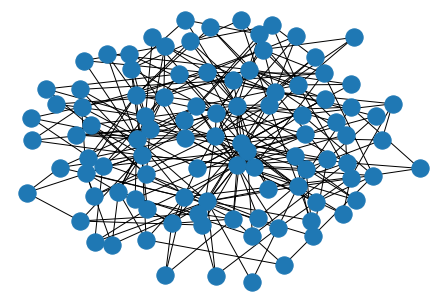

In [11]:
# use the networkx package to parse it and plot it
socialnet = nx.node_link_graph(network)
nx.draw_kamada_kawai(socialnet)

In [12]:
# get the genealogy tree
tree = game.getTree()

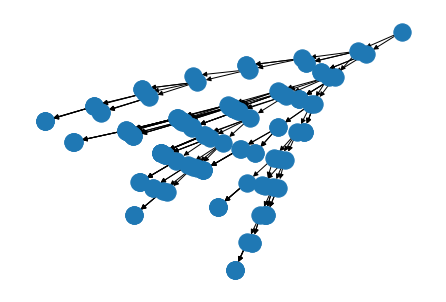

In [13]:
# use networkx to parse and plot it
genealogy = nx.tree_graph(tree)
nx.draw_kamada_kawai(genealogy)

In [14]:
# we can get hints every 6 seconds or so, let's grab a few rounds of hints

# note that you can now do getHints(hintstart=4)  where the number indicates
# from when to give you the hints (so this will give you everything from time
# unit 4 until now)
for i in np.arange(0,3):
    # this will give us just the new hints, but the object will store everything we've seen
    hints = game.getHints()
    if ('parts' in hints):
        print('we got '+str(len(hints['parts']))+' part hints')
    time.sleep(6)


# get all the hints we've collected
predHints = game.getAllPredictionHints()
partHints = game.getAllPartHints()

we got 0 part hints
we got 6 part hints
we got 12 part hints


In [15]:
# make the time hints into a dataframe
predhints_df = pd.read_json(json.dumps(predHints),orient='records')

In [16]:
# lets plot the data we got from all the robots
alt.Chart(predhints_df).mark_point().encode(
    x='time:Q',
    y='mean(value):Q'
)

alt.Chart(...)

In [17]:
# we can tell the hacker we're interested in robots 99, 23 and 1
game.setRobotInterest([99,23,5])

# to reset to being interested in all, use
# game.setRobotInterest([])

{'Result': 'OK'}

In [18]:
# we can also tell the hacker we're interesed in the 'Astrogation Buffer Length','InfoCore Size'
game.setPartInterest(['Astrogation Buffer Length','InfoCore Size'])

# to reset to being interested in all, use
# game.setPartInterest([])

{'Result': 'OK'}

In [19]:
# if we get more hints now, they'll be biased to the robots and parts we care about

for i in np.arange(0,3):
    # this will give us just the new hints, but the object will store everything we've seen
    hints = game.getHints()
    if ('parts' in hints):
        print('we got '+str(len(hints['parts']))+' part hints')
    time.sleep(6)

we got 12 part hints
we got 12 part hints
we got 12 part hints


In [20]:
# to set our bets, feed in a dictionary with the values
# for example, let's set robot id 0 to 99 and robot 5 to 72
game.setBets({0:99,5:72})

{'Result': 'OK'}

In [21]:
# let's see how we're doing, grab the data
robots = game.getRobotInfo()

In [22]:
# let's see how team 2 is doing (might be 0 if no deadlines expired)
robots[robots.winner == 2]['Productivity'].sum()

0.0

In [23]:
# let's see how team 1 is doing (might be 0 if no deadlines expired or we didn't put in any bets)
robots[robots.winner == 1]['Productivity'].sum()

0.0

In [24]:
# Here's a hint on how you can use the data you get to predict the value.
# Let's say we learn two points about a robot's random number generator
# At time 17, they'll say 40 and at time 50, they'll say 27
xs = [17,50]
ys = [40,27]

In [25]:
# we can use this to generate simple regression. One way to do it is to just fit a one dimensional polynomial
fit = np.polyfit(xs,ys,1)

# in reality, 1 dimension is probably not ideal

In [26]:
# next, we'll want to figure out all the y values over the range of times 0 to 100
fitx = np.arange(0,100)
fity = []

In [27]:
# create the fit function using the fit we calculated above
fitfunc = np.poly1d(fit)
for x in fitx:
    y = fitfunc(x)
    if (y > 100): # we know y can't be > 100
        y = 100
    if (y < 0): # we know y can't be < 0
        y = 0
    fity.append(y)

In [28]:
# to visualize this, I'm going to build a dataset the has both the original numbers 
# our hacker gave us (17,50 and 40,27) and the new things we calculated:
vals = []
for i in np.arange(0,len(xs)):
    vals.append({'t':'hint','x':int(xs[i]),'y':int(ys[i])})
   
for i in np.arange(0,len(fitx)):
    vals.append({'t':'fit','x':int(fitx[i]),'y':int(fity[i])})

# so now we have a dataset with both the hint and fit data
# you can look at it here
# vals

In [29]:
# finally, let's plot the data using Altair

# first make a chart for the hints
hintlayer = alt.Chart(alt.Data(values=vals)).mark_circle(filled=True,size=90,color='red').encode(
    x='x:Q',
    y='y:Q',
    color='t:N'
).transform_filter(
    alt.datum.t == 'hint'
)

# overlay that with the predictions
fitlayer = alt.Chart(alt.Data(values=vals)).mark_line().encode(
    x='x:Q',
    y='y:Q',
    color='t:N'
).transform_filter(
    alt.datum.t == 'fit'
)

# and let's assume an expiration of 70 for this robot and draw a line on top

annotationlayer = alt.Chart(pd.DataFrame({'x': [70]})).mark_rule().encode(x='x:Q')

# layer the charts
hintlayer + fitlayer + annotationlayer


alt.LayerChart(...)

## A few other random "recipes"

In [30]:
# set all the bets to 80
bets = {}
for i in np.arange(0,100):
    bets[int(i)] = int(80)
game.setBets(bets)

{'Result': 'OK'}

In [31]:
# get all the game parts since the start of the game
game.getHints(hintstart=0)['parts']

[{'column': 'Nanochip Model', 'id': 77, 'value': 'windows 2000'},
 {'column': 'Sonoreceptors', 'id': 38, 'value': 83.0},
 {'column': 'Repulsorlift Motor HP', 'id': 87, 'value': 82.04971563320159},
 {'column': 'Polarity Sinks', 'id': 39, 'value': 0.9535159253200312},
 {'column': 'Cranial Uplink Bandwidth', 'id': 37, 'value': 61.0},
 {'column': 'InfoCore Size', 'id': 52, 'value': 1.0550965733705344},
 {'column': 'Polarity Sinks', 'id': 38, 'value': 0.3534601874082676},
 {'column': 'Axial Piston Model', 'id': 13, 'value': 'gamma'},
 {'column': 'Nanochip Model', 'id': 70, 'value': 'windows 2000'},
 {'column': 'InfoCore Size', 'id': 47, 'value': 1.597074170461037},
 {'column': 'Axial Piston Model', 'id': 65, 'value': 'beta'},
 {'column': 'Axial Piston Model', 'id': 82, 'value': 'kappa'},
 {'column': 'Astrogation Buffer Length',
  'id': 93,
  'value': 0.4021538544350777},
 {'column': 'Sonoreceptors', 'id': 75, 'value': 58.0},
 {'column': 'Axial Piston Model', 'id': 71, 'value': 'gamma'},
 {'

In [32]:
# debug information while game is in simulation
game.getDebug()

{'team1secret': 'bob',
 'team2secret': '2287d89b-9cce-4717-a76e-1048fb18c694',
 'team1_int_bots': [[],
  [],
  [],
  [99, 23, 5],
  [99, 23, 5],
  [99, 23, 5],
  [99, 23, 5],
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'team2_int_bots': [[],
  [],
  [],
  [],
  [],
  [],
  [],
  None,
  No